In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/avhranalytics/test_KaymcHn.csv
/kaggle/input/avhranalytics/train_jqd04QH.csv
/kaggle/input/avhranalytics/sample_submission_sxfcbdx.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
SEED = 1
from numpy.random import seed
seed(SEED)
import os
os.environ['PYTHONHASHSEED']=str(SEED)

tf.random.set_seed(SEED)

In [4]:
train_df = pd.read_csv("/kaggle/input/avhranalytics/train_jqd04QH.csv")
test_df = pd.read_csv("/kaggle/input/avhranalytics/test_KaymcHn.csv")
sample_sub = pd.read_csv("/kaggle/input/avhranalytics/sample_submission_sxfcbdx.csv")

In [5]:
train_df.shape, test_df.shape, sample_sub.shape

((18359, 14), (15021, 13), (15021, 2))

In [6]:
train_df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [7]:
experience_mapping = {
    '<1' : 'entry_level',
    '1' : 'entry_level',
    '2' : 'mid_level',
    '3' : 'mid_level',
    '4' : 'mid_level',
    '5' : 'mid_level',
    '6' : 'senior_level',
    '7' : 'senior_level',
    '8' : 'senior_level',
    '9' : 'senior_level',
    '10' : 'senior_level',
    '11' : 'executive_level',
    '12' : 'executive_level',
    '13' : 'executive_level',
    '14' : 'executive_level',
    '15' : 'executive_level',
    '16' : 'senior_executive_level',
    '17' : 'senior_executive_level',
    '18' : 'senior_executive_level',
    '19' : 'senior_executive_level',
    '20' : 'senior_executive_level',
    '>20' : 'senior_executive_level',    
    'Unknown': 'Unknown'
}

In [8]:
def experience_foo(exp):
#     print(exp, exp in experience_mapping)
    return experience_mapping[exp]

In [9]:
# test_df.experience.apply(experience_foo)

In [10]:
train_df.groupby(['company_type'])['target'].mean()

company_type
Early Stage Startup    0.127148
Funded Startup         0.092486
NGO                    0.129213
Other                  0.159664
Public Sector          0.152610
Pvt Ltd                0.109143
Name: target, dtype: float64

In [11]:
X = train_df.drop(['enrollee_id', 'target'], axis=1)
y = train_df.target
XTest = test_df.drop(['enrollee_id'], axis=1)

# Analysis of duplicate enteries

In [12]:
X.columns

Index(['city', 'city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours'],
      dtype='object')

In [13]:
# X['city_development_index_qcut'] = pd.qcut(X.city_development_index.values.reshape(-1), 5, duplicates='drop', labels=False)
# XTest['city_development_index_qcut'] = pd.qcut(XTest.city_development_index.values.reshape(-1), 5, duplicates='drop', labels=False)

# X['training_hours_qcut'] = pd.qcut(X.training_hours.values.reshape(-1), 5, duplicates='drop', labels=False)
# XTest['training_hours_qcut'] = pd.qcut(XTest.training_hours.values.reshape(-1), 5, duplicates='drop', labels=False)


In [14]:
def auc(y_true, y_pred):
    def fallback_auc(y_true, y_pred):
        try:
            return metrics.roc_auc_score(y_true, y_pred)
        except:
            return 0.5
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

In [15]:
def create_model(data, catcols):    
    inputs = []
    outputs = []
    for c in catcols:
        num_unique_values = int(data[c].nunique())
        embed_dim = int(min(np.ceil((num_unique_values)/2), 50))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(0.3)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
    
    x = layers.Concatenate()(outputs)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(300, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(300, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    
    y = layers.Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=y)
    return model

In [16]:
data = pd.concat([X, XTest]).reset_index(drop=True)

features = [x for x in data.columns ]

for feat in features:
    lbl_enc = LabelEncoder()
    data[feat] = lbl_enc.fit_transform(data[feat].fillna("-1").astype(str).values)

In [17]:
train = data[:X.shape[0]]
test = data[X.shape[0]:]

In [18]:
train.shape, test.shape

((18359, 12), (15021, 12))

In [19]:
n_splits = 5

In [20]:
# test_data = [test.loc[:, features].values[:, k] for k in range(test.loc[:, features].values.shape[1])]
# oof_preds = np.zeros((len(train)))
# test_preds = np.zeros((len(test)))
# skf = StratifiedKFold(n_splits=n_splits)
# for train_index, test_index in skf.split(train, y):
#     X_train, X_test = train.iloc[train_index], train.iloc[test_index]
#     X_train = X_train.reset_index(drop=True)
#     X_test = X_test.reset_index(drop=True)
#     y_train, y_test = y[train_index],  y[test_index]
# #     y_train, y_test = X_train.target.values, X_test.target.values
#     model = create_model(data, features)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
#     X_train = [X_train.loc[:, features].values[:, k] for k in range(X_train.loc[:, features].values.shape[1])]
#     X_test = [X_test.loc[:, features].values[:, k] for k in range(X_test.loc[:, features].values.shape[1])]
    
#     es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=5,
#                                  verbose=1, mode='max', baseline=None, restore_best_weights=True)

#     rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
#                                       patience=3, min_lr=1e-6, mode='max', verbose=1)
    
#     model.fit(X_train,
#               utils.to_categorical(y_train),
#               validation_data=(X_test, utils.to_categorical(y_test)),
#               verbose=1,
#               batch_size=1024,
#               callbacks=[es, rlr],
#               epochs=100
#              )
#     valid_fold_preds = model.predict(X_test)[:, 1]
#     test_fold_preds = model.predict(test_data)[:, 1]
#     oof_preds[test_index] = valid_fold_preds.ravel()
#     test_preds += test_fold_preds.ravel()
#     print(metrics.roc_auc_score(y_test, valid_fold_preds))
#     K.clear_session()

In [21]:
# print("Overall AUC={}".format(metrics.roc_auc_score(y, oof_preds)))

In [22]:
# test_preds /= n_splits 
# test_ids = sample_sub.enrollee_id.values
# print("Saving submission file")
# mlp_submission = pd.DataFrame.from_dict({
#     'enrollee_id': test_ids,
#     'target': test_preds
# })
# mlp_submission.to_csv("mlp_submission.csv", index=False)

In [23]:
# sns.distplot(mlp_submission.target)

# Add target encoding + OHE

In [24]:
train_df = pd.read_csv("/kaggle/input/avhranalytics/train_jqd04QH.csv")
test_df = pd.read_csv("/kaggle/input/avhranalytics/test_KaymcHn.csv")
sample_sub = pd.read_csv("/kaggle/input/avhranalytics/sample_submission_sxfcbdx.csv")

In [25]:
# train_df[train_df.city.isnull()][['city','city_development_index']]

In [26]:
train_df.fillna('Unknown', inplace=True)
test_df.fillna('Unknown', inplace=True)


In [27]:
X = train_df.drop(['enrollee_id','target', 'city_development_index'], axis=1)
y = train_df['target'].copy()
XTest = test_df.drop(['enrollee_id', 'city_development_index'], axis=1)

In [28]:
# X['is_duplicated'] = X.duplicated()
# XTest['is_duplicated'] = XTest.duplicated()

In [29]:
high_cardinality_features =  X.columns

In [30]:
oof = pd.DataFrame([])
smoothing = 0.50

In [31]:
import category_encoders as ce

In [32]:
for tr_idx, oof_idx in StratifiedKFold(n_splits=5, random_state=2020, shuffle=True).split(X, y):
    ce_target_encoder = ce.TargetEncoder(cols = high_cardinality_features, smoothing=smoothing)
    ce_target_encoder.fit(X.iloc[tr_idx, :], y.iloc[tr_idx])
    oof = oof.append(ce_target_encoder.transform(X.iloc[oof_idx, :]), ignore_index=False)
ce_target_encoder = ce.TargetEncoder(cols = high_cardinality_features, smoothing=smoothing)

In [33]:
ce_target_encoder = ce.TargetEncoder(cols = high_cardinality_features, smoothing=smoothing)
ce_target_encoder.fit(X, y);  
test = ce_target_encoder.transform(XTest)

In [34]:
oof = oof.sort_index()

In [35]:
oof.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.113924,0.124420,0.116659,0.115402,0.142325,0.136733,0.152452,0.100561,0.108682,0.134267,0.108108
1,0.116667,0.121218,0.117788,0.115325,0.142277,0.137095,0.131524,0.105215,0.094952,0.136009,0.129630
2,0.086503,0.151112,0.116659,0.115402,0.142325,0.136733,0.138239,0.097377,0.158163,0.134394,0.109948
3,0.073684,0.122668,0.118063,0.117851,0.141038,0.136801,0.131846,0.103641,0.110449,0.133970,0.113514
4,0.148325,0.154315,0.175416,0.115272,0.119356,0.136849,0.114379,0.190550,0.180833,0.143234,0.146667


In [36]:
X_trans = oof
XTest_trans = test

In [37]:
X_raw = train_df.drop(['enrollee_id', 'target'], axis=1)
XTest_raw = test_df.drop(['enrollee_id'], axis=1)


In [38]:
# X_raw['is_duplicated'] = X_raw.duplicated()
# XTest_raw['is_duplicated'] = XTest_raw.duplicated()

In [39]:
exp_map = train_df.groupby(['experience'])['target'].mean()

In [40]:
# X_raw.experience.map(exp_map)

In [41]:
X_raw['city_development_index_qcut'] = pd.qcut(X_raw.city_development_index.values.reshape(-1), 5, duplicates='drop', labels=False)
XTest_raw['city_development_index_qcut'] = pd.qcut(XTest_raw.city_development_index.values.reshape(-1), 5, duplicates='drop', labels=False)

X_raw['training_hours_qcut'] = pd.qcut(X_raw.training_hours.values.reshape(-1), 5, duplicates='drop', labels=False)
XTest_raw['training_hours_qcut'] = pd.qcut(XTest_raw.training_hours.values.reshape(-1), 5, duplicates='drop', labels=False)

X_raw['city_development_index_qcut_10'] = pd.qcut(X_raw.city_development_index.values.reshape(-1), 10, duplicates='drop', labels=False)
XTest_raw['city_development_index_qcut_10'] = pd.qcut(XTest_raw.city_development_index.values.reshape(-1), 10, duplicates='drop', labels=False)

X_raw['training_hours_qcut_10'] = pd.qcut(X_raw.training_hours.values.reshape(-1), 10, duplicates='drop', labels=False)
XTest_raw['training_hours_qcut_10'] = pd.qcut(XTest_raw.training_hours.values.reshape(-1), 10, duplicates='drop', labels=False)


X_raw['experience_level_cat'] = X_raw.experience.apply(experience_foo)
XTest_raw['experience_level_cat'] = XTest_raw.experience.apply(experience_foo)


# X_raw['experience_me'] = X_raw.experience.apply(experience_foo)
# XTest_raw['experience_me'] = XTest_raw.experience.apply(experience_foo)

In [42]:
X_raw.drop(['city_development_index'], axis=1, inplace=True)
XTest_raw.drop(['city_development_index'], axis=1, inplace=True)

# X_raw.drop(['training_hours'], axis=1, inplace=True)
# XTest_raw.drop(['training_hours'], axis=1, inplace=True)


In [43]:
X_raw.columns

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job', 'training_hours',
       'city_development_index_qcut', 'training_hours_qcut',
       'city_development_index_qcut_10', 'training_hours_qcut_10',
       'experience_level_cat'],
      dtype='object')

In [44]:
XTest_raw.columns

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job', 'training_hours',
       'city_development_index_qcut', 'training_hours_qcut',
       'city_development_index_qcut_10', 'training_hours_qcut_10',
       'experience_level_cat'],
      dtype='object')

In [45]:
X_raw.shape, XTest_raw.shape

((18359, 16), (15021, 16))

In [46]:
from sklearn.preprocessing import OneHotEncoder

In [47]:
ohe = OneHotEncoder(sparse=False)

In [48]:
ohe.fit(X_raw)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [49]:
X_ohe = pd.DataFrame(ohe.transform(X_raw), columns=ohe.get_feature_names())
XTest_ohe = pd.DataFrame(ohe.transform(XTest_raw), columns=ohe.get_feature_names())

In [50]:
X_ohe['city_development_index'] = train_df.city_development_index
XTest_ohe['city_development_index'] = test_df.city_development_index

In [51]:
# X_ohe['training_hours'] = train_df.training_hours
# XTest_ohe['training_hours'] = test_df.training_hours


In [52]:
X_ohe.shape, XTest_ohe.shape

((18359, 467), (15021, 467))

In [53]:
X_all = pd.concat([X_trans, X_ohe], axis=1)
XTest_all = pd.concat([XTest_trans, XTest_ohe], axis=1)

In [54]:
X_all.shape, XTest_all.shape

((18359, 478), (15021, 478))

In [55]:
RANDOM_SEED = 1

In [56]:
import xgboost as xgb
import lightgbm as lgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X_all, y, 
                                                      random_state=RANDOM_SEED, 
                                                      test_size=0.2)

In [58]:
X_train.shape, X_valid.shape

((14687, 478), (3672, 478))

In [59]:
hyperopt_params = []

In [60]:
def score(params):
#     try:

    print("Training with params: ",params)
#     num_round = int(params['n_estimators'])
    del params['n_estimators']
    num_round = 10000
    dtrain = xgb.DMatrix(X_train.values, label=y_train)
    dvalid = xgb.DMatrix(X_valid.values, label=y_valid)
    watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=100,
                         early_stopping_rounds=100,
                         )
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
#         predictions = (predictions >= 0.5).astype('int')
    score = roc_auc_score(y_valid, predictions)
    print("+++++++++++++++++++++++++++++++++++++")
    print("Estimator",gbm_model.best_iteration)
    print("\tScore {0}\n\n".format(score))
    hyperopt_params.append((score, params, gbm_model.best_iteration))
    print("/////////////////////////////////////////")

    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


# In case of any exception or assertionerror making score 0, so that It can return maximum loss (ie 1)
#     except AssertionError as obj:
#         print("AssertionError: ",obj)
#         loss = 1 - 0
#         return {'loss': loss, 'status': STATUS_OK}

#     except Exception as obj:
#         print("Exception: ",obj)
#         loss = 1 - 0
#         return {'loss': loss, 'status': STATUS_OK}

In [61]:
def optimize(
             trials, 
             max_evals, 
             random_state=RANDOM_SEED):


    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
        'n_estimators': hp.quniform('n_estimators', 10, 300, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 7, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'scale_pos_weight': hp.quniform('scale_pos_weight', 1,4, 0.05),
        "reg_alpha": hp.quniform('reg_alpha', 0, 1, 0.05),
        "reg_lambda": hp.quniform('reg_lambda', 1, 5, 0.05),
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state,
        'eval_metric': 'auc'
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, 
                space, 
                algo=tpe.suggest, 
                trials=trials, 
                max_evals=max_evals)
    return best

In [62]:
trials = Trials()
MAX_EVALS = 25

best_hyperparams = optimize(trials, MAX_EVALS)
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.275, 'eval_metric': 'auc', 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6.0, 'n_estimators': 209.0, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 0.25, 'reg_lambda': 1.6500000000000001, 'scale_pos_weight': 3.9000000000000004, 'seed': 1, 'silent': 1, 'subsample': 0.55, 'tree_method': 'exact'}
[0]	train-auc:0.65195	eval-auc:0.65099

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.


Will train until eval-auc hasn't improved in 100 rounds.

[100]	train-auc:0.81996	eval-auc:0.65846

Stopping. Best iteration:
[9]	train-auc:0.70222	eval-auc:0.66794


+++++++++++++++++++++++++++++++++++++
Estimator
9
	Score 0.667941579066275


/////////////////////////////////////////
Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.275, 'eval_metric': 'auc', 'gamma': 0.9, 'max_depth': 6, 'min_child_weight': 4.0, 'n_estimators': 99.0,

In [63]:
# sorted(hyperopt_params, reverse=True)

In [64]:
# best_hyperparams

In [65]:
# param = best_hyperparams
# num_round = int(param['n_estimators'])
# del param['n_estimators']

In [66]:
best_till_now = (0.6893537283878427,
 {'booster': 'gbtree',
  'colsample_bytree': 0.9500000000000001,
  'eta': 0.2,
  'eval_metric': 'auc',
  'gamma': 0.9500000000000001,
  'max_depth': 2,
  'min_child_weight': 2.0,
  'nthread': 4,
  'objective': 'binary:logistic',
  'reg_alpha': 0.35000000000000003,
  'reg_lambda': 4.25,
  'scale_pos_weight': 1.05,
  'seed': 1,
  'silent': 1,
  'subsample': 0.75,
  'tree_method': 'exact',
  'validate_parameters': 1},
 138)

In [67]:
current_best = sorted(hyperopt_params, reverse=True)[0]

In [68]:
if current_best[0] > best_till_now[0]:
    print("Found new best")
    print(current_best)
    param = current_best[1]
    param['n_estimators'] = current_best[2]
else:
    print("using previous best")
    print(best_till_now)
    param = best_till_now[1]
    param['n_estimators'] = best_till_now[2]

# del param['seed']
param 

Found new best
(0.6913352027323347, {'booster': 'gbtree', 'colsample_bytree': 1.0, 'eta': 0.07500000000000001, 'eval_metric': 'auc', 'gamma': 0.65, 'max_depth': 6, 'min_child_weight': 2.0, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 0.8, 'reg_lambda': 4.25, 'scale_pos_weight': 3.45, 'seed': 1, 'silent': 1, 'subsample': 0.75, 'tree_method': 'exact', 'validate_parameters': 1}, 46)


{'booster': 'gbtree',
 'colsample_bytree': 1.0,
 'eta': 0.07500000000000001,
 'eval_metric': 'auc',
 'gamma': 0.65,
 'max_depth': 6,
 'min_child_weight': 2.0,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0.8,
 'reg_lambda': 4.25,
 'scale_pos_weight': 3.45,
 'seed': 1,
 'silent': 1,
 'subsample': 0.75,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'n_estimators': 46}

In [69]:
# param = {'colsample_bytree': 0.65,
#  'eta': 0.025,
#  'gamma': 0.8500000000000001,
#  'max_depth': 4,
#  'min_child_weight': 1.0,
#  'n_estimators': 107.0,
#  'reg_alpha': 1.0,
#  'reg_lambda': 3.35,
#  'scale_pos_weight': 2.1,
#  'subsample': 0.9,
#  'eval_metric': 'auc'
# }

# num_round = int(param['n_estimators'])
# del param['n_estimators']


# {'booster': 'gbtree',
#   'colsample_bytree': 0.9500000000000001,
#   'eta': 0.2,
#   'eval_metric': 'auc',
#   'gamma': 0.9500000000000001,
#   'max_depth': 2,
#   'min_child_weight': 2.0,
#   'nthread': 4,
#   'objective': 'binary:logistic',
#   'reg_alpha': 0.35000000000000003,
#   'reg_lambda': 4.25,
#   'scale_pos_weight': 1.05,
#   'seed': 1,
#   'silent': 1,
#   'subsample': 0.75,
#   'tree_method': 'exact',
#   'validate_parameters': 1,
#   'n_estimators': 138
# }

In [70]:
# num_round = 10000
# dtrain = xgb.DMatrix(X_train.values, label=y_train)
# dvalid = xgb.DMatrix(X_valid.values, label=y_valid)
# watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
# gbm_model = xgb.train(param, dtrain, num_round,
#                       evals=watchlist,
#                       verbose_eval=100,
#                      early_stopping_rounds=100,
#                      )
# predictions = gbm_model.predict(dvalid,
#                                 ntree_limit=gbm_model.best_iteration + 1)
# #         predictions = (predictions >= 0.5).astype('int')
# score = roc_auc_score(y_valid, predictions)
# print("+++++++++++++++++++++++++++++++++++++")
# print("Estimator",gbm_model.best_iteration)
# print("\tScore {0}\n\n".format(score))


In [71]:
num_round = param['n_estimators']

In [72]:
# model = xgb.XGBClassifier(random_state=RANDOM_SEED, seed=RANDOM_SEED, **param, n_estimators=num_round)
# model = xgb.XGBClassifier(random_state=RANDOM_SEED, seed=RANDOM_SEED, **param)

dtrain_full = xgb.DMatrix(X_all.values, label=y)

model = xgb.train(param, dtrain_full, 
                  num_round,
                  verbose_eval=100,
                 )
# predictions = gbm_model.predict(dvalid, ntree_limit=gbm_model.best_iteration + 1)

In [73]:
# model.fit(X_all.values, y)

In [74]:
dxtest = xgb.DMatrix(XTest_all.values)

In [75]:
# pred_test = model.predict_proba(XTest_all.values)[:,1]
pred_test = model.predict(dxtest, ntree_limit=model.best_iteration + 1)

In [76]:
test_ids = sample_sub.enrollee_id.values
print("Saving submission file")
xgb_best_param_with_full_data_training = pd.DataFrame.from_dict({
    'enrollee_id': test_ids,
    'target': pred_test.reshape(-1)
})
xgb_best_param_with_full_data_training.to_csv("xgb_best_param_with_full_data_training.csv", index=False)

Saving submission file


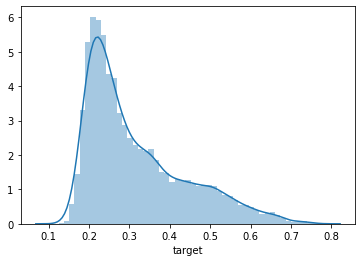

In [77]:
sns.distplot(xgb_best_param_with_full_data_training.target)

In [78]:
from xgboost import XGBClassifier

In [79]:
dxtest = xgb.DMatrix(XTest_all.values)

num_splits = 20
skf = StratifiedKFold(n_splits= num_splits, random_state=42, shuffle=False)

# y_test_pred = np.zeros((XTest_trans.shape[0], 1))
y_test_pred = np.zeros((XTest_all.shape[0], 1))

print(y_test_pred.shape)
y_valid_scores = []

X = X_all
# clf = lgb_clf

fold_cnt = 1
for train_index, test_index in skf.split(X, y):
    print("FOLD .... ",fold_cnt)
    fold_cnt += 1
    
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_valid = y[train_index], y[test_index]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    
    evallist = [(dtrain, 'train'), (dvalid, 'eval')]

    # Training xgb model
    num_round = 10000
    bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=50, early_stopping_rounds=100)
    
    # Predict Validation
#     y_pred_valid = bst.predict(dvalid, ntree_limit=bst.best_iteration + 1)
    
#     clf = clf.fit(X_train, y_train,
#                           eval_set = [(X_train, y_train), 
#                                       (X_valid, y_valid)],
#                           verbose = 1000,
#                           eval_metric = 'auc',
#                           early_stopping_rounds = 10)
        
#     clf.fit(X_train, y_train)
    print("trained....")
    
    #Predict validation data
    y_pred_valid = bst.predict(dvalid, ntree_limit=bst.best_iteration+1)
    print(np.round(roc_auc_score(y_valid, y_pred_valid),4))
    y_valid_scores.append(roc_auc_score(y_valid, y_pred_valid))
    
    #Predict test data
#     y_pred = clf.predict_proba(XTest_trans.values)[:,1]
    y_pred = bst.predict(dxtest, ntree_limit=bst.best_iteration+1)
    
    print(y_pred.shape)
    y_test_pred += y_pred.reshape(-1,1)

(15021, 1)
FOLD ....  1
[0]	train-auc:0.67749	eval-auc:0.66594
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[50]	train-auc:0.80006	eval-auc:0.70193
[100]	train-auc:0.84434	eval-auc:0.69666
Stopping. Best iteration:
[42]	train-auc:0.79094	eval-auc:0.70301

trained....
0.703
(15021,)
FOLD ....  2
[0]	train-auc:0.67732	eval-auc:0.62060
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[50]	train-auc:0.80438	eval-auc:0.68173
[100]	train-auc:0.84853	eval-auc:0.67926
Stopping. Best iteration:
[27]	train-auc:0.76977	eval-auc:0.68671

trained....
0.6867
(15021,)
FOLD ....  3
[0]	train-auc:0.67758	eval-auc:0.63326
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[50]	train-auc:0.80480	eval-auc:0.64569
[100]	train-auc:

In [80]:
np.round(y_valid_scores,4)

array([0.703 , 0.6867, 0.6569, 0.677 , 0.6399, 0.6694, 0.6695, 0.6328,
       0.7598, 0.6099, 0.6628, 0.6539, 0.6723, 0.6653, 0.7052, 0.692 ,
       0.6766, 0.7114, 0.656 , 0.674 ])

In [81]:
np.mean(y_valid_scores)

0.6737166393637644

In [82]:
0.6713033440878389

0.6713033440878389

In [83]:
y_test_pred /= num_splits

In [84]:
y_test_pred.reshape(-1)

array([0.54161397, 0.26367144, 0.63486437, ..., 0.26488244, 0.44768284,
       0.44622528])

In [85]:
test_ids = sample_sub.enrollee_id.values
print("Saving submission file")
xgb_submission = pd.DataFrame.from_dict({
    'enrollee_id': test_ids,
    'target': y_test_pred.reshape(-1)
})
xgb_submission.to_csv("xgb_submission.csv", index=False)

Saving submission file


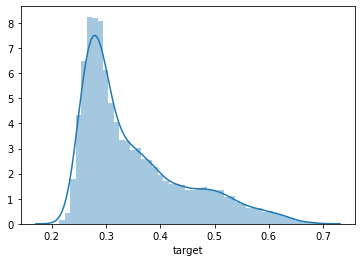

In [86]:
sns.distplot(xgb_submission.target)

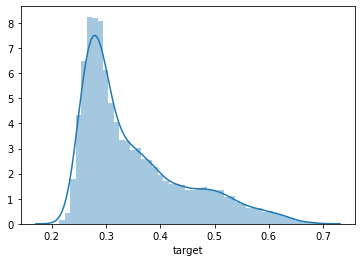

In [87]:
sns.distplot(xgb_submission.target)
# sns.distplot(mlp_submission.target)

In [88]:
ensemble_pred = xgb_best_param_with_full_data_training.target + xgb_submission.target
ensemble_pred /= 2

In [89]:
test_ids = sample_sub.enrollee_id.values
print("Saving submission file")
ensemble_xgb_mlp = pd.DataFrame.from_dict({
    'enrollee_id': test_ids,
    'target': ensemble_pred
})
ensemble_xgb_mlp.to_csv("ensemble_submission.csv", index=False)

Saving submission file


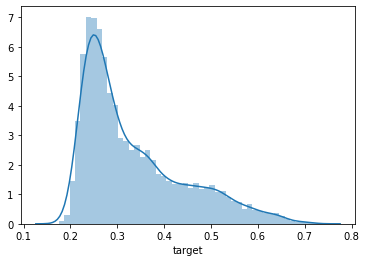

In [90]:
sns.distplot(ensemble_xgb_mlp.target)